In [3]:
from xgboost import XGBClassifier


In [5]:
#تجهيز بيئة العمل والأدوات اللي هنستخدمها في كل المراحل الجاية.

In [7]:
# ====== 0. Imports & Settings ======
import os
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

# set display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)


In [9]:
import pandas as pd

# تحميل كل الملفات
demo = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\DEMO_L.XPT")
bmx = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\BMX_L.XPT")
bp = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\BPXO_L.XPT")
diq = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\DIQ_L.XPT")
glu = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\GLU_L.XPT")
hdl = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\HDL_L.XPT")
tri = pd.read_sas(r"C:\Users\janaa\Downloads\NHANES_L_Data\TRIGLY_L.XPT")

# دمجهم باستخدام رقم التعريف (عادة العمود اسمه SEQN)
data = demo.merge(bmx, on="SEQN", how="inner")\
           .merge(bp, on="SEQN", how="inner")\
           .merge(diq, on="SEQN", how="inner")\
           .merge(glu, on="SEQN", how="inner")\
           .merge(hdl, on="SEQN", how="inner")\
           .merge(tri, on="SEQN", how="inner")

# نحفظ نسخة مدمجة
data.to_csv(r"C:\Users\janaa\Downloads\NHANES_L_Data\diabetes_dataset.csv", index=False)

print("✅ تم إنشاء ملف diabetes_dataset.csv بنجاح!")
print("عدد الصفوف:", len(data))
print("عدد الأعمدة:", len(data.columns))


✅ تم إنشاء ملف diabetes_dataset.csv بنجاح!
عدد الصفوف: 3996
عدد الأعمدة: 82


In [11]:
#قراءة الملفات +  فحصها +  عرض الأعمدة والمعلومات الأساسية

In [13]:
from tabulate import tabulate
import pandas as pd
import os

# Load NHANES XPT files
data_dir = r"C:\Users\janaa\Downloads\NHANES_L_Data"

files = ["DIQ_L.XPT", "DEMO_L.XPT", "BMX_L.XPT", "BPXO_L.XPT", "GLU_L.XPT", "HDL_L.XPT", "TRIGLY_L.XPT"]
datasets = [(name.split("_")[0], pd.read_sas(os.path.join(data_dir, name))) for name in files]

# Summary
print("\n" + "="*80)
print("Summary of Loaded NHANES XPT Files".center(80))
print("="*80 + "\n")

summary = [[name, df.shape[0], df.shape[1]] for name, df in datasets]
summary_df = pd.DataFrame(summary, columns=["Dataset", "Rows", "Columns"])
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid", showindex=False))
print("\n")

# Display first two rows and column names
for name, df in datasets:
    print(f"\n{'-'*80}")
    print(f"Dataset: {name} | Shape: {df.shape}")
    print("-"*80)
    print(tabulate(df.head(2), headers="keys", tablefmt="rounded_outline", showindex=False, numalign="right"))
    print("\nColumns:")
    print(", ".join(df.columns))
    print("-"*80)



                       Summary of Loaded NHANES XPT Files                       

╒═══════════╤════════╤═══════════╕
│ Dataset   │   Rows │   Columns │
╞═══════════╪════════╪═══════════╡
│ DIQ       │  11744 │         9 │
├───────────┼────────┼───────────┤
│ DEMO      │  11933 │        27 │
├───────────┼────────┼───────────┤
│ BMX       │   8860 │        22 │
├───────────┼────────┼───────────┤
│ BPXO      │   7801 │        12 │
├───────────┼────────┼───────────┤
│ GLU       │   3996 │         4 │
├───────────┼────────┼───────────┤
│ HDL       │   8068 │         4 │
├───────────┼────────┼───────────┤
│ TRIGLY    │   3996 │        10 │
╘═══════════╧════════╧═══════════╛



--------------------------------------------------------------------------------
Dataset: DIQ | Shape: (11744, 9)
--------------------------------------------------------------------------------
╭────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬───────────┬──────────╮
│   SEQN │   DIQ010 │   

In [15]:
#المرحلة الأولى من المشروع: Data Loading, Cleaning & Saving

In [17]:
import os
import pandas as pd
import numpy as np
from tabulate import tabulate

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)

# 1. Load data
data_dir = r"C:\Users\janaa\Downloads\NHANES_L_Data"
files = {
    "DIQ": "DIQ_L.XPT",
    "DEMO": "DEMO_L.XPT",
    "BMX": "BMX_L.XPT",
    "BPXO": "BPXO_L.XPT",
    "GLU": "GLU_L.XPT",
    "HDL": "HDL_L.XPT",
    "TRIG": "TRIGLY_L.XPT"
}
dfs = {k: pd.read_sas(os.path.join(data_dir, v)) for k, v in files.items()}

summary = pd.DataFrame([(k, df.shape[0], df.shape[1]) for k, df in dfs.items()],
                       columns=["Dataset", "Rows", "Columns"])
print(tabulate(summary, headers="keys", tablefmt="fancy_grid"))

# 2. Select relevant columns
cols = {
    "DIQ": ["SEQN", "DIQ010"],
    "DEMO": ["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1"],
    "BMX": ["SEQN", "BMXBMI", "BMXWT", "BMXHT"],
    "BPXO": ["SEQN", "BPXOSY1", "BPXODI1", "BPXOSY2", "BPXODI2", "BPXOSY3", "BPXODI3"],
    "GLU": ["SEQN", "LBXGLU"],
    "HDL": ["SEQN", "LBDHDD"],
    "TRIG": ["SEQN", "LBXTLG", "LBDTRSI"]
}

def safe_select(df, cols):
    return df[[c for c in cols if c in df.columns]].copy()

dfs_sel = {k: safe_select(df, cols[k]) for k, df in dfs.items()}

# 3. Clean target
if "DIQ010" in dfs_sel["DIQ"].columns:
    dfs_sel["DIQ"]["DIQ010"] = dfs_sel["DIQ"]["DIQ010"].replace({1: 1, 2: 0})

# 4. Save processed data
os.makedirs("processed_data", exist_ok=True)
for k, df in dfs_sel.items():
    df.to_csv(f"processed_data/{k.lower()}_sel.csv", index=False)

print("\nAll cleaned files saved in 'processed_data' folder.\n")

# 5. Summary of selected columns
summary_cols = [[k, ", ".join(df.columns), df.shape[0], df.shape[1]] for k, df in dfs_sel.items()]
summary_df = pd.DataFrame(summary_cols, columns=["File", "Selected Columns", "Rows", "Cols"])
print(tabulate(summary_df, headers="keys", tablefmt="fancy_grid"))


╒════╤═══════════╤════════╤═══════════╕
│    │ Dataset   │   Rows │   Columns │
╞════╪═══════════╪════════╪═══════════╡
│  0 │ DIQ       │  11744 │         9 │
├────┼───────────┼────────┼───────────┤
│  1 │ DEMO      │  11933 │        27 │
├────┼───────────┼────────┼───────────┤
│  2 │ BMX       │   8860 │        22 │
├────┼───────────┼────────┼───────────┤
│  3 │ BPXO      │   7801 │        12 │
├────┼───────────┼────────┼───────────┤
│  4 │ GLU       │   3996 │         4 │
├────┼───────────┼────────┼───────────┤
│  5 │ HDL       │   8068 │         4 │
├────┼───────────┼────────┼───────────┤
│  6 │ TRIG      │   3996 │        10 │
╘════╧═══════════╧════════╧═══════════╛

All cleaned files saved in 'processed_data' folder.

╒════╤════════╤════════════════════════════════════════════════════════════╤════════╤════════╕
│    │ File   │ Selected Columns                                           │   Rows │   Cols │
╞════╪════════╪════════════════════════════════════════════════════════════╪

In [19]:
#handling the (outliers , invalid codes)

In [21]:
import numpy as np

# Replace outliers (7777, 9999) with NaN in all datasets
for name, df in dfs.items():
    df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
    print(f"Replaced 7777 and 9999 with NaN in {name}")
    print(df.isna().sum().head(), "\n")


Replaced 7777 and 9999 with NaN in DIQ
SEQN          0
DIQ010        4
DID040    10663
DIQ160     3722
DIQ180     3440
dtype: int64 

Replaced 7777 and 9999 with NaN in DEMO
SEQN        0
SDDSRVYR    0
RIDSTATR    0
RIAGENDR    0
RIDAGEYR    0
dtype: int64 

Replaced 7777 and 9999 with NaN in BMX
SEQN           0
BMDSTATS       0
BMXWT        106
BMIWT       8515
BMXRECUM    8406
dtype: int64 

Replaced 7777 and 9999 with NaN in BPXO
SEQN         0
BPAOARM      0
BPAOCSZ    190
BPXOSY1    284
BPXODI1    284
dtype: int64 

Replaced 7777 and 9999 with NaN in GLU
SEQN          0
WTSAF2YR      0
LBXGLU      324
LBDGLUSI    324
dtype: int64 

Replaced 7777 and 9999 with NaN in HDL
SEQN           0
WTPH2YR        0
LBDHDD      1178
LBDHDDSI    1178
dtype: int64 

Replaced 7777 and 9999 with NaN in TRIG
SEQN          0
WTSAF2YR      0
LBXTLG      479
LBDTRSI     479
LBDLDL      516
dtype: int64 



In [23]:
#Phase 2: Data Preparation / Integration

In [25]:
import pandas as pd

# Load processed CSV files
diq = pd.read_csv("processed_data/diq_sel.csv")
demo = pd.read_csv("processed_data/demo_sel.csv")
bmx = pd.read_csv("processed_data/bmx_sel.csv")
bpxo = pd.read_csv("processed_data/bpxo_sel.csv")
glu = pd.read_csv("processed_data/glu_sel.csv")
hdl = pd.read_csv("processed_data/hdl_sel.csv")
trig = pd.read_csv("processed_data/trig_sel.csv")

# Select and rename columns
diq_sel = diq[['SEQN', 'DIQ010']].rename(columns={'DIQ010': 'diabetes'})
demo_sel = demo[['SEQN', 'RIDAGEYR', 'RIAGENDR']].rename(columns={'RIDAGEYR': 'age', 'RIAGENDR': 'gender'})
bmx_sel = bmx[['SEQN', 'BMXBMI']]
bpxo_sel = bpxo[['SEQN', 'BPXOSY1', 'BPXODI1']].rename(columns={'BPXOSY1': 'systolic_bp', 'BPXODI1': 'diastolic_bp'})
glu_sel = glu[['SEQN', 'LBXGLU']].rename(columns={'LBXGLU': 'glucose'})
hdl_sel = hdl[['SEQN', 'LBDHDD']].rename(columns={'LBDHDD': 'hdl'})
trig_sel = trig[['SEQN', 'LBDTRSI']].rename(columns={'LBDTRSI': 'triglyceride'})

# Merge all datasets
df = (
    diq_sel
    .merge(demo_sel, on='SEQN', how='left')
    .merge(bmx_sel, on='SEQN', how='left')
    .merge(bpxo_sel, on='SEQN', how='left')
    .merge(glu_sel, on='SEQN', how='left')
    .merge(hdl_sel, on='SEQN', how='left')
    .merge(trig_sel, on='SEQN', how='left')
)

# Display result
print(f"Merged shape: {df.shape}")
print(df.head())


Merged shape: (11744, 10)
       SEQN  diabetes   age  gender  BMXBMI  systolic_bp  diastolic_bp  glucose   hdl  triglyceride
0  130378.0       0.0  43.0     1.0    27.0        135.0          98.0    113.0  45.0         1.727
1  130379.0       0.0  66.0     1.0    33.5        121.0          84.0     99.0  60.0         0.971
2  130380.0       1.0  44.0     2.0    29.7        111.0          79.0    156.0  49.0         4.234
3  130381.0       0.0   5.0     2.0    23.8          NaN           NaN      NaN   NaN           NaN
4  130382.0       0.0   2.0     1.0     NaN          NaN           NaN      NaN   NaN           NaN


In [27]:
# توزيع الإصابة بالسكري حسب العمر (Boxplot)

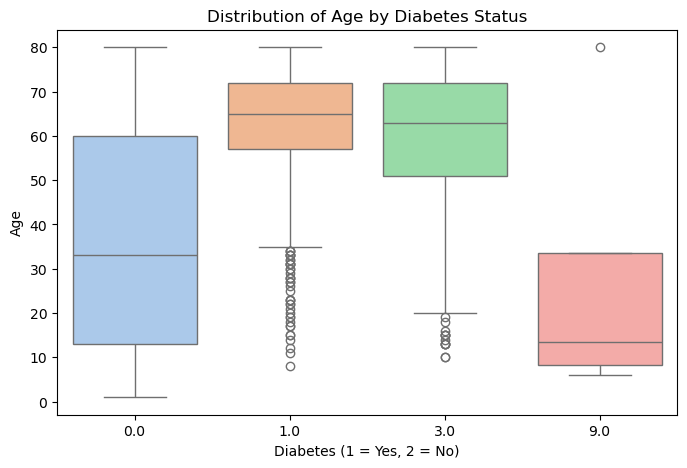

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='diabetes', y='age', hue='diabetes', data=df, palette='pastel', legend=False)

plt.title("Distribution of Age by Diabetes Status")
plt.xlabel("Diabetes (1 = Yes, 2 = No)")
plt.ylabel("Age")
plt.show()


In [31]:
#توزيع الإصابة بالسكري حسب الجنس (Countplot)

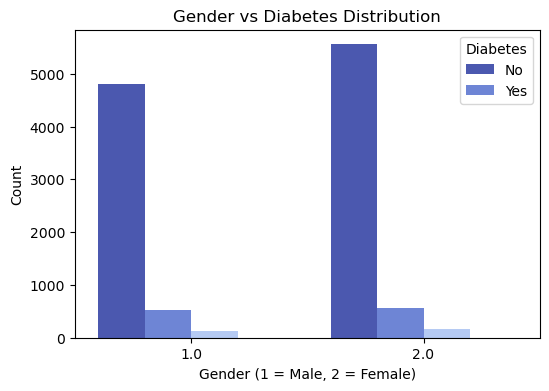

In [33]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='diabetes', data=df, palette='coolwarm')
plt.title("Gender vs Diabetes Distribution")
plt.xlabel("Gender (1 = Male, 2 = Female)")
plt.ylabel("Count")
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.show()


In [35]:
#مقارنة متوسط Glucose و HDL بين المصابين وغير المصابين

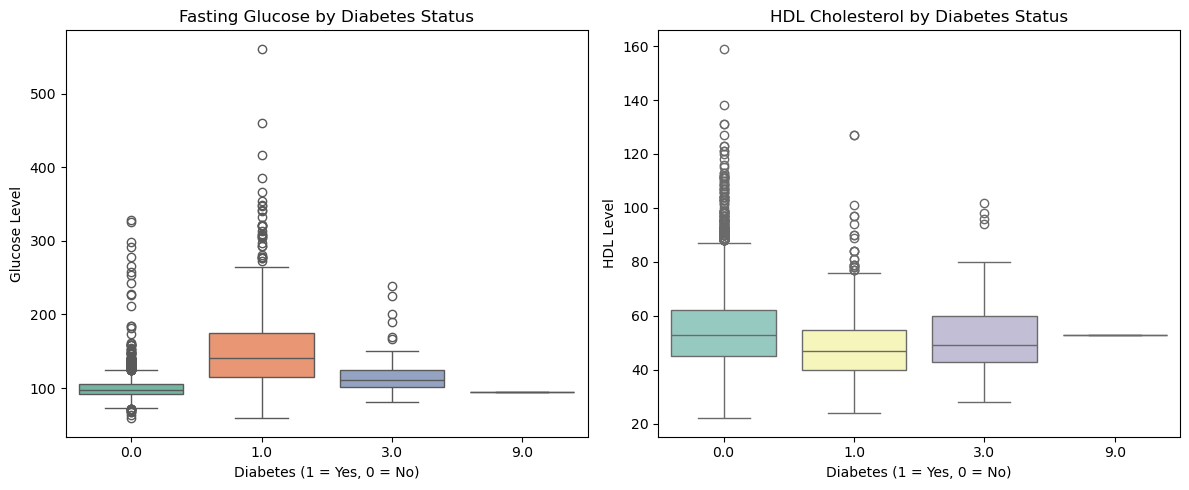

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Glucose comparison
plt.subplot(1,2,1)
sns.boxplot(x='diabetes', y='glucose', data=df, hue='diabetes', palette='Set2', legend=False)
plt.title("Fasting Glucose by Diabetes Status")
plt.xlabel("Diabetes (1 = Yes, 0 = No)")
plt.ylabel("Glucose Level")

# HDL comparison
plt.subplot(1,2,2)
sns.boxplot(x='diabetes', y='hdl', data=df, hue='diabetes', palette='Set3', legend=False)
plt.title("HDL Cholesterol by Diabetes Status")
plt.xlabel("Diabetes (1 = Yes, 0 = No)")
plt.ylabel("HDL Level")

plt.tight_layout()
plt.show()


In [39]:
#Phase 2 — Feature Engineering & Cleaning


In [41]:
import numpy as np
import pandas as pd

if "diabetes" in df.columns:
    df["diabetes"] = df["diabetes"].replace({1: 1, 2: 0})
    df.loc[~df["diabetes"].isin([0, 1]), "diabetes"] = np.nan

    print(f"Before drop: {df.shape}")
    df = df.dropna(subset=["diabetes"]).copy()
    print(f"After drop: {df.shape}\n")

    important_cols = ["SEQN", "diabetes", "age", "gender", "BMXBMI", "glucose", "hdl", "triglyceride"]
    print("Missing values:\n")
    for col in important_cols:
        if col in df.columns:
            print(f"{col:<12}: {df[col].isnull().sum()} / {df.shape[0]}")
else:
    print("Column 'diabetes' not found.")


Before drop: (11744, 10)
After drop: (11452, 10)

Missing values:

SEQN        : 0 / 11452
diabetes    : 0 / 11452
age         : 0 / 11452
gender      : 0 / 11452
BMXBMI      : 3212 / 11452
glucose     : 7910 / 11452
hdl         : 4770 / 11452
triglyceride: 8057 / 11452


In [43]:
#التعامل مع القيم المفقودة (Handling Missing Values)

In [45]:
import numpy as np
import pandas as pd

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ["SEQN", "DIQ010", "diabetes"]:
    if col in num_cols:
        num_cols.remove(col)

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

missing_pct = df.isnull().mean()
high_missing = missing_pct[missing_pct > 0.5]

if not high_missing.empty:
    print("Columns with >50% missing values:\n")
    print(high_missing)
else:
    print("No columns have more than 50% missing values.")


No columns have more than 50% missing values.


In [47]:
#المرحلة رقم 6 – Exploratory Data Analysis (EDA)

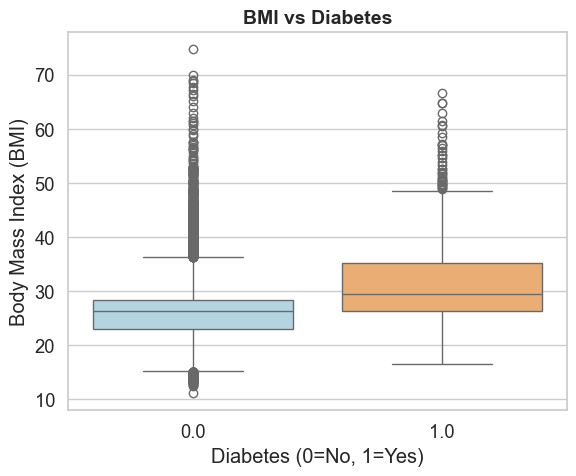

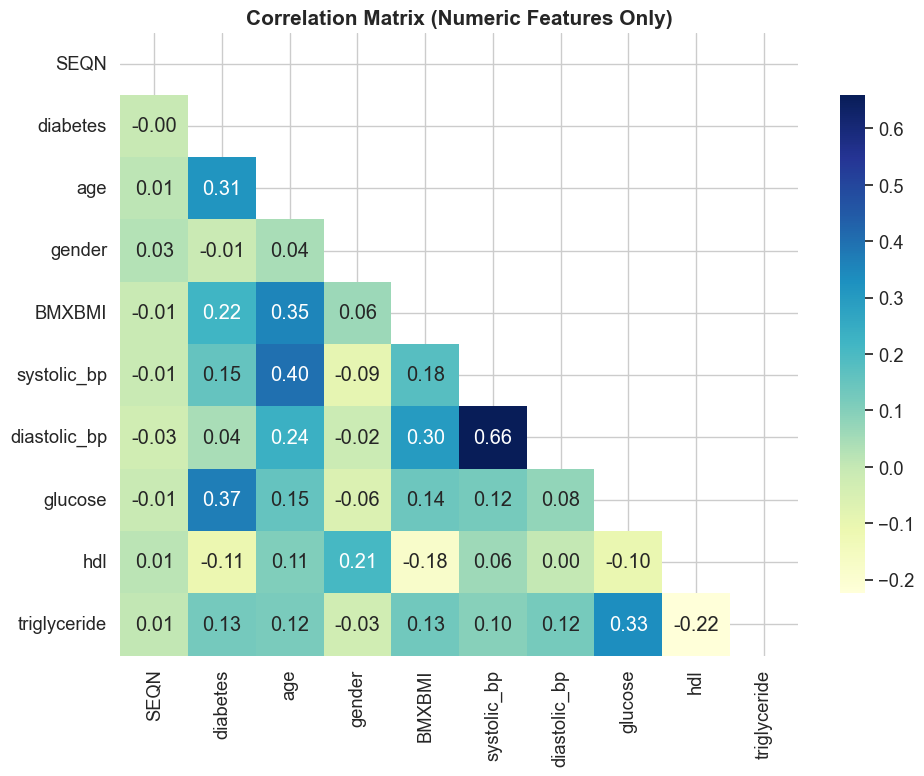

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.2)

# 1. Age distribution by diabetes status
if "RIDAGEYR" in df.columns and "diabetes" in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x="RIDAGEYR", hue="diabetes", kde=True, bins=30, alpha=0.6)
    plt.title("Age Distribution by Diabetes Status", fontsize=14, fontweight='bold')
    plt.xlabel("Age (years)")
    plt.ylabel("Count")
    plt.legend(title="Diabetes", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()

# 2. Glucose vs diabetes
if "LBXGLU" in df.columns and "diabetes" in df.columns:
    plt.figure(figsize=(6,5))
    sns.boxplot(data=df, x="diabetes", y="LBXGLU", hue="diabetes", palette=["#91bfdb", "#fc8d59"], legend=False)
    plt.title("Fasting Glucose Levels vs Diabetes", fontsize=14, fontweight='bold')
    plt.xlabel("Diabetes (0=No, 1=Yes)")
    plt.ylabel("Fasting Glucose (mg/dL)")
    plt.tight_layout()
    plt.show()

# 3. BMI vs diabetes
if "BMXBMI" in df.columns and "diabetes" in df.columns:
    plt.figure(figsize=(6,5))
    sns.boxplot(data=df, x="diabetes", y="BMXBMI", hue="diabetes", palette=["#abd9e9", "#fdae61"], legend=False)
    plt.title("BMI vs Diabetes", fontsize=14, fontweight='bold')
    plt.xlabel("Diabetes (0=No, 1=Yes)")
    plt.ylabel("Body Mass Index (BMI)")
    plt.tight_layout()
    plt.show()

# 4. Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.title("Correlation Matrix (Numeric Features Only)", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


In [51]:
#Data Preparation & Splitting

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

features = []
for c in ["RIDAGEYR", "RIAGENDR", "RIDRETH1", "BMXBMI", "LBXGLU", "LBXTR", "LBDHDD", "BPXOSY1", "BPXODI1"]:
    if c in df.columns:
        features.append(c)

X = df[features].copy()
y = df["diabetes"].copy()

valid_labels = [0.0, 1.0]
mask = y.isin(valid_labels)
X = X[mask]
y = y[mask].astype(int)


y = y.replace({1.0: 1, 2.0: 0}).astype(int)

X = pd.get_dummies(X, columns=[c for c in ["RIAGENDR", "RIDRETH1"] if c in X.columns], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/test sizes:", X_train.shape, X_test.shape)
print("Unique y_train labels:", y_train.unique())


Train/test sizes: (9161, 1) (2291, 1)
Unique y_train labels: [0 1]


In [55]:
#Model Training & Evaluation

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}


results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
        if probs.shape[1] == 2:
            probs = probs[:, 1]
            roc = roc_auc_score(y_test, probs)
        else:
            roc = roc_auc_score(y_test, probs, multi_class="ovr")
    else:
        roc = None
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4),
        "ROC-AUC": round(roc, 4) if roc is not None else None
    })

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)
print("Model Performance Comparison:\n")
print(results_df.to_string(index=False))


Model Performance Comparison:

              Model  Accuracy  F1 Score  ROC-AUC
Logistic Regression    0.9031    0.8612   0.6947
            XGBoost    0.9057    0.8609   0.6693
      Random Forest    0.8992    0.8592   0.6056


In [59]:
df["diabetes"].value_counts(dropna=False)


diabetes
0.0    10371
1.0     1081
Name: count, dtype: int64

In [61]:
#Hyperparameter Tuning & Model Optimization

In [91]:
# ====== المكتبات ======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report

# ====== تجهيز X و y ======
features = [c for c in ["RIDAGEYR", "RIAGENDR", "RIDRETH1", "BMXBMI", "LBXGLU", "LBXTR", "LBDHDD", "BPXOSY1", "BPXODI1"] if c in df.columns]
X = df[features].copy()
y = df["diabetes"].copy()

# الاحتفاظ بالفئات الصحيحة فقط (0 و 1)
y = y.replace({1.0: 1, 2.0: 0}).astype(int)

# تحويل categorical إلى dummy variables
X = pd.get_dummies(X, columns=[c for c in ["RIAGENDR","RIDRETH1"] if c in X.columns], drop_first=True)

# Standardize الأرقام
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسيم البيانات مع stratify لتوازن الفئات
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/test sizes:", X_train.shape, X_test.shape)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

# ====== تعريف الموديلات ======
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

# ====== تدريب الموديلات وحساب الأداء ======
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # ROC-AUC بس لو فيه أكتر من فئة
    if hasattr(model, "predict_proba") and len(y_test.unique()) > 1:
        probs = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, probs)
    else:
        roc = None
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")
    prec = precision_score(y_test, preds, average="weighted", zero_division=0)
    rec = recall_score(y_test, preds, average="weighted", zero_division=0)
    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4),
        "ROC-AUC": round(roc, 4) if roc is not None else None
    })

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)
print("\nModel Performance Comparison:\n")
print(results_df.to_string(index=False))

# ====== Hyperparameter Tuning للـ Random Forest ======
from scipy.stats import randint

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20)
}

rf = RandomForestClassifier(random_state=42)
rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=30, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

best_rf = rs.best_estimator_
preds = best_rf.predict(X_test)

if len(y_test.unique()) > 1:
    probs = best_rf.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, probs)
else:
    roc = None

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, average="weighted", zero_division=0)
rec = recall_score(y_test, preds, average="weighted", zero_division=0)
f1 = f1_score(y_test, preds, average="weighted")

results_rf = pd.DataFrame([{
    "Model": "Random Forest (Tuned)",
    "Accuracy": round(acc, 4),
    "Precision": round(prec, 4),
    "Recall": round(rec, 4),
    "F1 Score": round(f1, 4),
    "ROC-AUC": round(roc, 4) if roc is not None else None
}])

print("\nTuned Random Forest Performance:\n")
print(results_rf.to_string(index=False))
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, preds, digits=4, zero_division=0))



Train/test sizes: (9161, 1) (2291, 1)
Train class distribution:
 diabetes
0    8296
1     865
Name: count, dtype: int64
Test class distribution:
 diabetes
0    2075
1     216
Name: count, dtype: int64

Model Performance Comparison:

              Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
Logistic Regression    0.9031     0.8396  0.9031    0.8612   0.6947
            XGBoost    0.9057     0.8203  0.9057    0.8609   0.6693
      Random Forest    0.8992     0.8303  0.8992    0.8592   0.6056

Tuned Random Forest Performance:

                Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
Random Forest (Tuned)    0.9057     0.8203  0.9057    0.8609   0.6977

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.9057    1.0000    0.9505      2075
           1     0.0000    0.0000    0.0000       216

    accuracy                         0.9057      2291
   macro avg     0.4529    0.5000    0.4753      2291
weighted avg  

In [93]:
#ROC Curve للموديل الأفضل (مثلاً الـ Random Forest tuned)

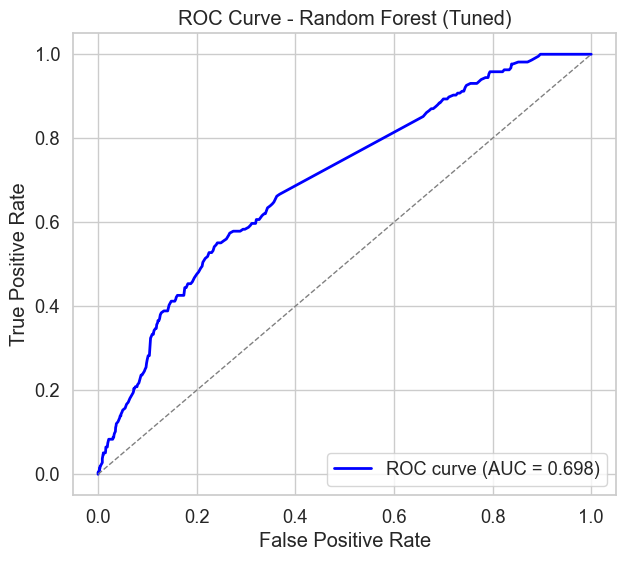

In [97]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# استخدم best_rf و X_test_scaled
probs = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Tuned)")
plt.legend(loc="lower right")
plt.show()


In [99]:
#Feature Importance للـ Random Forest

C:\Users\janaa\AppData\Local\Temp\ipykernel_12240\804424729.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


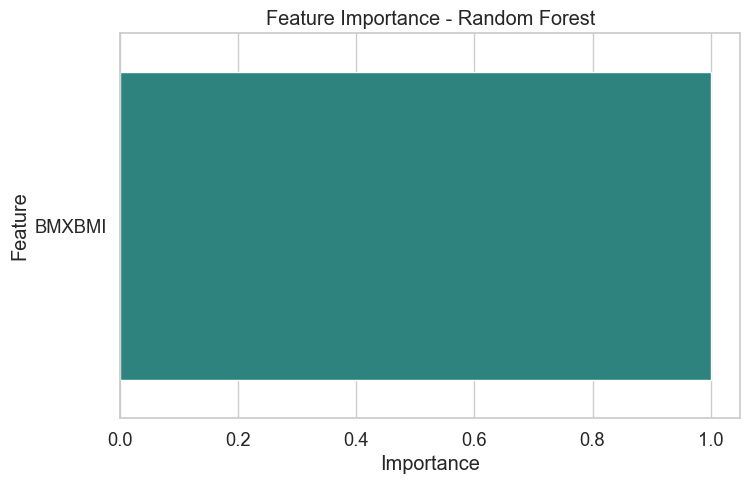

In [101]:
import pandas as pd
import seaborn as sns

# الحصول على Feature Importances
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [103]:
#(Model Training & Evaluation)

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from scipy.stats import randint
import pandas as pd
from tabulate import tabulate

# ===== Hyperparameter distribution =====
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20)
}

# ===== Create Random Forest model =====
rf = RandomForestClassifier(random_state=42)

# ===== Randomized Search =====
rs = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42
)
rs.fit(X_train, y_train)

# ===== Best model =====
best_rf = rs.best_estimator_
best_params = rs.best_params_

# ===== Predictions =====
preds = best_rf.predict(X_test)
probs = best_rf.predict_proba(X_test)[:, 1]

# ===== Metrics =====
roc_auc = roc_auc_score(y_test, probs)
report = classification_report(y_test, preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T.reset_index().rename(columns={'index': 'Metric'})

cm = confusion_matrix(y_test, preds)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# ===== Display results =====
print("\nBest Hyperparameters:")
print(tabulate(pd.DataFrame([best_params]), headers="keys", tablefmt="fancy_grid"))

print(f"\nRandom Forest ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(tabulate(report_df.round(3), headers="keys", tablefmt="fancy_grid", showindex=False))

print("\nConfusion Matrix:")
print(tabulate(cm_df, headers="keys", tablefmt="fancy_grid"))



Best Hyperparameters:
╒════╤═════════════╤════════════════════╤═════════════════════╤════════════════╕
│    │   max_depth │   min_samples_leaf │   min_samples_split │   n_estimators │
╞════╪═════════════╪════════════════════╪═════════════════════╪════════════════╡
│  0 │           3 │                 12 │                  13 │            444 │
╘════╧═════════════╧════════════════════╧═════════════════════╧════════════════╛

Random Forest ROC-AUC: 0.6977

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Metric       │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │       0.906 │    1     │      0.951 │  2075     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │       0     │    0     │      0     │   216     │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │       0.906 │    0.906 │      0

In [111]:
#Model Saving Stage"

In [115]:

import joblib
import os

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "best_rf_model.joblib")
scaler_path = os.path.join(save_dir, "scaler.joblib")

joblib.dump(best_rf, model_path)
joblib.dump(scaler, scaler_path)

print("\n Models have been successfully saved!")
print(f" Model saved to: {model_path}")
print(f" Scaler saved to: {scaler_path}")



 Models have been successfully saved!
 Model saved to: saved_models\best_rf_model.joblib
 Scaler saved to: saved_models\scaler.joblib


In [127]:
# ====== 1. المكتبات ======
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib, os

# ====== 2. تحديد الأعمدة المستخدمة ======
features = ["age", "gender", "BMXBMI", "systolic_bp", "diastolic_bp", "glucose", "hdl", "triglyceride"]

# اختار الأعمدة اللي موجودة فعلًا في df
features = [f for f in features if f in df.columns]

# ====== 3. تجهيز X و y ======
X = df[features].copy()
y = df["diabetes"].replace({1.0: 1, 2.0: 0}).astype(int)

# one-hot encoding
X = pd.get_dummies(X, columns=["gender"], drop_first=True)

# ====== 4. Standardization ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ====== 5. تقسيم البيانات ======
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ====== 6. تدريب Random Forest ======
model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# ====== 7. التقييم ======
preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]
print("\nAccuracy:", round(accuracy_score(y_test, preds), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, probs), 4))
print("\nClassification Report:\n", classification_report(y_test, preds, digits=4))

# ====== 8. حفظ الموديل و الـ scaler ======
os.makedirs("saved_models", exist_ok=True)
joblib.dump(model, "saved_models/best_rf_model.joblib")
joblib.dump(scaler, "saved_models/scaler.joblib")

# حفظ أسماء الأعمدة علشان Streamlit يستخدمها بنفس الترتيب
joblib.dump(X.columns.tolist(), "saved_models/feature_names.joblib")

print("\n✅ Model & Scaler & Feature Names Saved Successfully!")
print(f"Number of features used: {len(X.columns)}")



Accuracy: 0.9241
ROC-AUC: 0.8856

Classification Report:
               precision    recall  f1-score   support

           0     0.9268    0.9947    0.9596      2075
           1     0.8281    0.2454    0.3786       216

    accuracy                         0.9241      2291
   macro avg     0.8775    0.6200    0.6691      2291
weighted avg     0.9175    0.9241    0.9048      2291


✅ Model & Scaler & Feature Names Saved Successfully!
Number of features used: 8
